len(sha_001_df_drtn) : 4037, the total records number.
split_idx: 3229


len(hidden_states_seq_train) : 3229
len(hidden_states_seq_test) : 808

trained_hmm.transmat_:
[[ 0.66497411  0.00020484  0.27795786  0.05587437  0.00068241  0.00030641]
 [ 0.00002941  0.27207924  0.00003139  0.00003414  0.00000195  0.72782387]
 [ 0.70286299  0.0007401   0.24769914  0.04405055  0.00248926  0.00215798]
 [ 0.65383013  0.01218261  0.24429492  0.03841443  0.00887022  0.04240768]
 [ 0.77004705  0.00187695  0.20481313  0.01123121  0.00304607  0.00898559]
 [ 0.00253426  0.27741733  0.00655206  0.01158948  0.00030556  0.70160131]]

Means and vars of each hidden state
0th hidden state
mean =  [ 0.00022861]
var =  [ 0.00008788]

1th hidden state
mean =  [-0.00623011]
var =  [ 0.00133667]

2th hidden state
mean =  [ 0.00016421]
var =  [ 0.00023827]

3th hidden state
mean =  [-0.00305711]
var =  [ 0.00056055]

4th hidden state
mean =  [ 0.0396896]
var =  [ 0.00441381]

5th hidden state
mean =  [ 0.00283182]
var =  [ 0.00039901]



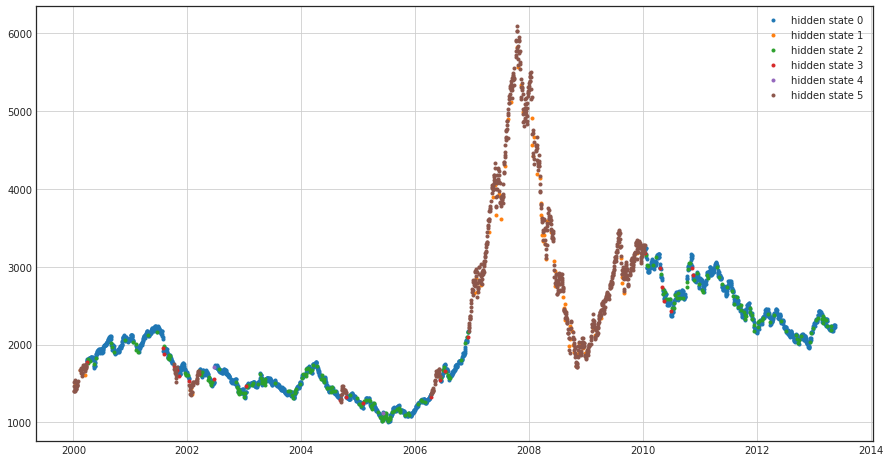

In [10]:
import numpy as np
from hmmlearn import hmm
import warnings
from sklearn import neighbors, preprocessing
import pandas as pd
import seaborn as sns
from analytic import utility
from analytic import ta_indicators, performance

from matplotlib import cm
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore", category=DeprecationWarning)
csv_files = ['SHA01']

# get raw, whole scale data
sha_001_df = utility.get_cols_from_csv_names(csv_files,
                                             interested_col=['Date', 'Open', 'Close', 'Volume'],
                                             join_spy_for_data_integrity=False,
                                             keep_spy_if_not_having_spy=False,
                                             base_dir='/home/boweiliu/workrepo/udacity_p_f/src/rawdata')
# reverse and select data required for study
sha_001_df = sha_001_df.iloc[::-1].loc['2000-01-04':'2016-09-02']
close = sha_001_df['SHA01_CLOSE']
volume = sha_001_df['SHA01_VOLUME']
date_list = pd.to_datetime(close.index)

rtn = ta_indicators.get_daily_return(close)
ln_rtn = ta_indicators.get_ln_return(close)
assert len(ln_rtn) > 0
rtn.iloc[0] = 0.001
ln_rtn.iloc[0] = 0.00001
print('len(sha_001_df_drtn) : {}, the total records number.'.format(len(ln_rtn)))
split_idx = int(len(ln_rtn) / 5.0 * 4.0)
print("split_idx: {}".format(split_idx))

close_pds_train = close.iloc[0:split_idx]
close_pds_test = close.iloc[split_idx:]

volume_pds_train = volume.iloc[0:split_idx]
volume_pds_test = volume.iloc[split_idx:]

# normal return
rtn_pds_train = rtn.iloc[0:split_idx]
rtn_pds_test = rtn.iloc[split_idx:]

# natural log return
ln_rtn_pds_train = ln_rtn.iloc[0:split_idx]
ln_rtn_pds_test = ln_rtn.iloc[split_idx:]

date_list_train = date_list[0:split_idx]
date_list_test = date_list[split_idx:]

X = np.column_stack([np.array(ln_rtn_pds_train)])
X_test = np.column_stack([np.array(ln_rtn_pds_test)])

trained_hmm = hmm.GaussianHMM(n_components=6, covariance_type='full', n_iter=5000)
# only use sample section to train model
trained_hmm.fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states_seq_train = trained_hmm.predict(X)
h_s_seq_test = trained_hmm.predict(X_test)

print('len(hidden_states_seq_train) : {}'.format(len(hidden_states_seq_train)))
print('len(hidden_states_seq_test) : {}'.format(len(h_s_seq_test)))

print("\ntrained_hmm.transmat_:")
print(trained_hmm.transmat_)
print("\nMeans and vars of each hidden state")
for i in range(trained_hmm.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", trained_hmm.means_[i])
    print("var = ", np.diag(trained_hmm.covars_[i]))
    print()

sns.set_style('white')
plt.figure(figsize=(15, 8))
for i in range(trained_hmm.n_components):
    state = (hidden_states_seq_train == i)
    #  https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot
    plt.plot(date_list_train[state],  # x series
             close_pds_train.iloc[state],  # y series
             '.',  # point marker
             label='hidden state {}'.format(i),
             linewidth=1)
    plt.legend()
    plt.grid(1)
plt.show()


hidden_state_classification : 
 [0, -1, 0, -1, 0, 1]


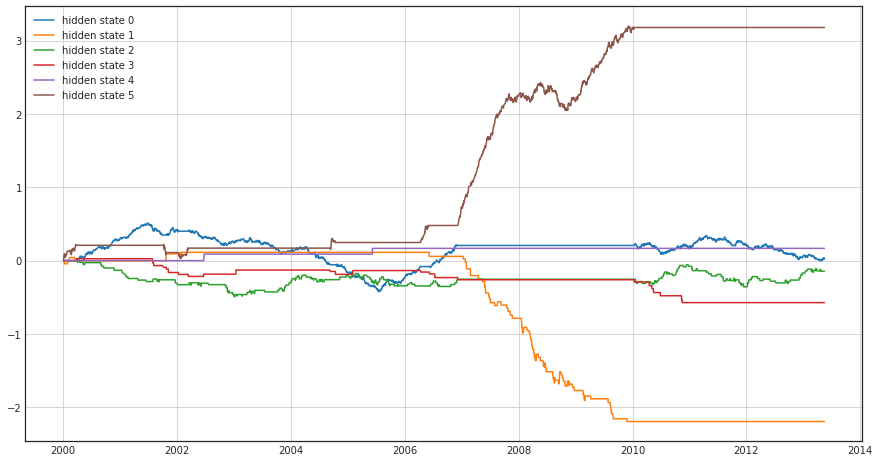

In [11]:
# start cell 2
h_s_class = []

plt.figure(figsize=(15, 8))
for state_i in range(trained_hmm.n_components):
    mask = [1 if state else 0 for state in (hidden_states_seq_train == state_i)]
    log_cum_rtn = ln_rtn_pds_train.multiply(mask, axis=0).cumsum()
    if log_cum_rtn.iloc[-1] > 0.5:
        # market up
        h_s_class.append(1)
    elif log_cum_rtn.iloc[-1] < -0.5:
        # market down
        h_s_class.append(-1)
    else:
        # market vibrate
        h_s_class.append(0)
    plt.plot(log_cum_rtn, label='hidden state {}'.format(state_i))
    plt.legend()
    plt.grid(1)
print("hidden_state_classification : \n {}".format(h_s_class))
plt.show()

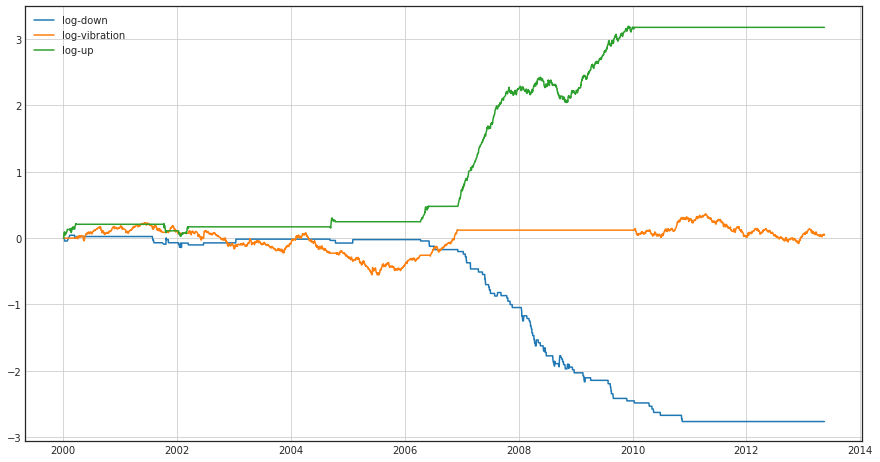

In [12]:
# start cell 3
# remapping hidden states sequence into assumed states sequence
assumed_states_seq_train = np.array(
    [h_s_class[hidden_state_i]
     for hidden_state_i in hidden_states_seq_train])
# -1 means market down
# 0 means market vibrate
# 1 means market up
# print(assumed_states_seq_train == 2)

plt.figure(figsize=(15, 8))
for state_i in [-1, 0, 1]:
    mask = [1 if assume_state == state_i else 0 for assume_state in assumed_states_seq_train]
    assumed_states_rtn = ln_rtn_pds_train.multiply(mask, axis=0)
    assumed_states_cum_rtn = assumed_states_rtn.cumsum()
    the_label = 'log-up' if state_i == 1 else 'log-down' if state_i == -1 else 'log-vibration'
    plt.plot(assumed_states_cum_rtn, label=the_label)
    plt.legend()
    plt.grid(1)
plt.show()

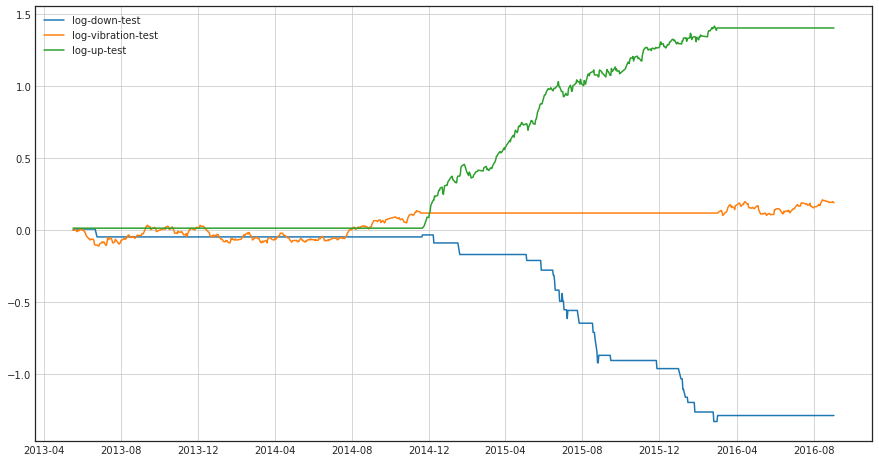

In [13]:

# start cell 4
# remapping hidden states sequence into assumed states sequence
assumed_states_seq_test = np.array([h_s_class[hsi] for hsi in h_s_seq_test])
# 0 means xia die
# 1 means zhengdang
# 2 means shangzhang
# print(assumed_states_seq_train == 2)

plt.figure(figsize=(15, 8))
for state_i in [-1, 0, 1]:
    mask = [1 if assume_state == state_i else 0 for assume_state in assumed_states_seq_test]
    assumed_states_rtn_test = ln_rtn_pds_test.multiply(mask, axis=0)
    assumed_states_cum_rtn_test = assumed_states_rtn_test.cumsum()
    the_label = 'log-up-test' if state_i == 1 else \
        'log-down-test' if state_i == -1 else 'log-vibration-test'
    plt.plot(assumed_states_cum_rtn_test, label=the_label)
    plt.legend()
    plt.grid(1)
plt.show()


In [18]:
in_sample_df = sha_001_df.iloc[0: split_idx]
test_df = sha_001_df.iloc[split_idx:]

in_sample_df = in_sample_df.assign(SHA01_SIGNAL=assumed_states_seq_train)
test_df = test_df.assign(SHA01_SIGNAL=assumed_states_seq_test)

net_worths_in_sample = performance.get_relative_net_worth(in_sample_df, 'SHA01')
print(net_worths_in_sample)
net_worths_test = performance.get_relative_net_worth(test_df, 'SHA01')
print(net_worths_test)

sharpe_ratio_in_sample = performance.get_sharp_ratio(net_worths_in_sample)
sharpe_ratio_test = performance.get_sharp_ratio(net_worths_test)
print(sharpe_ratio_in_sample, sharpe_ratio_test)

2000-01-04    1.000000
2000-01-05    1.001316
2000-01-06    1.039858
2000-01-07    1.077264
2000-01-10    1.097514
2000-01-11    1.051108
2000-01-12    1.072851
2000-01-13    1.063559
2000-01-14    1.051916
2000-01-17    1.070195
2000-01-18    1.065188
2000-01-19    1.075716
2000-01-20    1.095233
2000-01-21    1.093905
2000-01-24    1.103058
2000-01-25    1.102433
2000-01-26    1.105876
2000-01-27    1.125027
2000-01-28    1.146105
2000-02-14    1.249849
2000-02-15    1.305642
2000-02-16    1.316447
2000-02-17    1.275658
2000-02-18    1.296995
2000-02-21    1.304027
2000-02-22    1.269161
2000-02-23    1.240110
2000-02-24    1.270728
2000-02-25    1.268603
2000-02-28    1.325580
                ...   
2013-03-29    0.839091
2013-04-01    0.839091
2013-04-02    0.839091
2013-04-03    0.839091
2013-04-08    0.839091
2013-04-09    0.839091
2013-04-10    0.839091
2013-04-11    0.839091
2013-04-12    0.839091
2013-04-15    0.839091
2013-04-16    0.839091
2013-04-17    0.839091
2013-04-18 